In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [4]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [5]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID', 'lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
bad_samples = ['NA19328']
df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

## Raw # ICs detected per sample per map haplotype

In [17]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)

# remove sqanti genome and drop dupes
# the sqanti genome / sqanti metrics SHOULD be irrelevant here
df = df.drop(['sqanti_genome', 'canonical', 'splice_motif'], axis=1)
print(len(df.index))
df = df.drop_duplicates()
print(len(df.index))

df.head()

# then make sure that there are no dupe. ic+structural cat+sample+map genome
temp = df.loc[df[['sj_id', 'junction_novelty',
                  'cell_line_id', 'map_genome', 'start_site_novelty',
                  'end_site_category']].duplicated(keep=False)]
assert len(temp.index) == 0
del temp

df.rename({'end_site_category': 'end_site_novelty'}, axis=1, inplace=True)

# transform to be t/f for each ic per genome
temp = pd.crosstab(index=[df.sj_id, df.junction_novelty,
                                 df.start_site_novelty,
                                 df.end_site_novelty, df.cell_line_id], 
                          columns=df.map_genome, 
                          values=df.map_genome, 
                          aggfunc=lambda x: True).fillna(False).reset_index()

24934518
8311506


{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

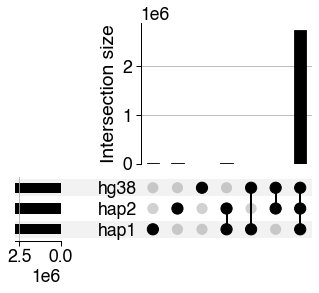

In [23]:
map_genomes = ['hg38', 'hap1', 'hap2']
temp = temp.set_index(map_genomes)

c_dict, order = get_novelty_colors()
init_plot_settings()
upset = upsetplot.UpSet(df_crosstab)
upset.plot()

In [24]:
df.head()

,sj_id,junction_novelty,start_site_novelty,end_site_novelty,cell_line_id,map_genome
0,KI270741.1_+_44470_47849,known,known,known,NA12273,hg38
1,KI270741.1_+_48008_52058,known,known,known,NA12273,hg38
2,KI270741.1_+_52137_130639,known,known,known,NA12273,hg38
3,KI270741.1_+_44470_47948,known,known,known,NA12273,hg38
4,GL000224.1_+_102592_105978,known,known,known,NA12273,hg38


In [26]:
# just look at raw counts differences
temp = df[['sj_id', 'cell_line_id', 'map_genome']].groupby(['cell_line_id', 'map_genome']).nunique().reset_index().rename({'sj_id':'n_sj'}, axis=1)

# do paired wilcoxon tests for each haplotype
temp = temp.pivot(index='cell_line_id', columns='map_genome', values='n_sj').reset_index()

# Wilcoxon test: hap1 vs hg38. hyp is that hap1 > hg38
stat, pval = st.wilcoxon(temp['hap1'].tolist(), temp['hg38'].tolist(), alternative='greater')
print(f"hap1 vs hg38: Wilcoxon stat = {stat}, p-value = {pval:.3f}")


# Wilcoxon test: hap2 vs hg38. hyp is that hap2 > hg38
stat, pval = st.wilcoxon(temp['hap2'].tolist(), temp['hg38'].tolist(), alternative='greater')
print(f"hap2 vs hg38: Wilcoxon stat = {stat}, p-value = {pval:.3f}")

hap1 vs hg38: Wilcoxon stat = 465.0, p-value = 0.000
hap2 vs hg38: Wilcoxon stat = 465.0, p-value = 0.000


In [27]:
temp['hap1_diff'] = temp['hap1']-temp['hg38']
temp['hap2_diff'] = temp['hap2']-temp['hg38']
temp['hap1_perc_diff'] = (temp['hap1_diff']/temp['hg38'])*100
temp['hap2_perc_diff'] = (temp['hap2_diff']/temp['hg38'])*100

In [28]:
import statistics
thing = temp.hap1_diff.tolist()+temp.hap2_diff.tolist()
statistics.median(thing)

496.0

In [29]:
import statistics
thing = temp.hap1_perc_diff.tolist()+temp.hap2_perc_diff.tolist()
statistics.median(thing)

0.551372618109572

In [30]:
print(len(temp.loc[temp.hap1_diff<0]))
print(len(temp.loc[temp.hap2_diff<0]))

0
0


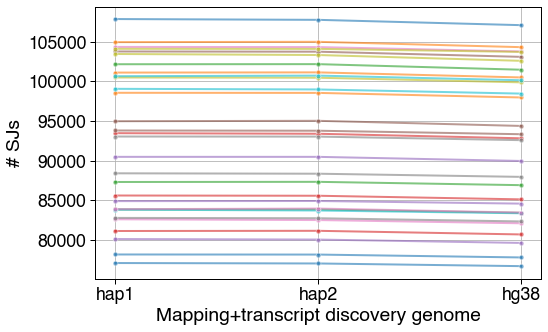

In [31]:
# visualization
init_plot_settings(aspect='square')
temp2 = temp.melt(id_vars=['cell_line_id'], 
                      value_vars=['hap1', 'hap2', 'hg38'], 
                      var_name='map_genome', 
                      value_name='n_sj')
temp2 = temp2.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=temp2, x='map_genome', y='n_sj', hue='cell_line_id', marker='o', palette="tab10",
             linewidth=2, alpha=0.6, legend=False)

plt.ylabel("# SJs")
plt.xlabel("Mapping+transcript discovery genome")
plt.grid(True)
plt.show()